# Dynamic Programming on the GPU: A Tutorial for Economists

Authors: [Thomas J Sargent](http://www.tomsargent.com/) and [John Stachurski](https://johnstachurski.net/)

Parallelization on GPUs is one of the major trends of modern scientific computing.

In this notebook we examine a simple implementation of dynamic programming on
the GPU using Python and the [Google JAX
library](https://jax.readthedocs.io/en/latest/index.html).

This notebook is intended for readers who are familiar with the basics of dynamic programming and want to learn about the JAX library and working on the GPU.

The notebook is part of the [QuantEcon](https://quantecon.org) project.

From our timing on Google Colab with a Tesla P100 GPU, the JAX based Bellman operator is 

* over 3000 times faster than a Numba-based JIT-compiled single-threaded version, and 
* almost 1500 times faster than a NumPy-based multithreaded version.

(The Numba-based version uses a similar compiler to Julia and, for this kind of problem, runs at a similar speed to compiled C and Fortran code.)

## How to Use this Notebook

If you are reading this as an executable notebook on Google Colab or elsewhere, please note:

* You might like to first read the notebook in its present form to see the timings that we obtain before you run it.
* We have a subscription to Google colab pro, which offers better GPUs than the free tier.  Consider subscribing as well, if you don't have access to a GPU and want to obtain timings similar to ours.

If you are reading this as a static web page (e.g., on QuantEcon Notes), then you can [switch to 
Google Colab by following this link](https://colab.research.google.com/drive/1Dt_Ah1X1e93PYWgxtjLtPg0nQRvC5rBR).

If you are on QuantEcon Notes and have feedback please provide it in the comments.


## A Savings Problem

To focus on implementation rather than technical details, we will adopt a very
familiar optimal savings problem as our running example.  

* For more details on this problem see, for example, [this QuantEcon
lecture](https://python.quantecon.org/ifp.html).
* For a more elementary discussion of optimal savings see [this discussion of
cake eating](https://python.quantecon.org/cake_eating_problem.html).

The problem is to maximize the expected discounted sum

$$
    \mathbb{E} \sum_{t \geq 0} \beta^t u(c_t)
$$

subject to 

$$
    c_t + a_{t+1} \leq R a_t + y_t, 
    \quad c_t \geq 0
    \quad a_t \geq 0
$$

for all $t \geq 0$, with $a_0$ and $y_0$ given.

Here 

* $c_t$ is consumption,
* $a_t$ is assets,
* $R$ is the gross risk-free rate of return, and
* $y_t$ is income.

The income process follows a Markov chain with transition matrix $P$.

The Bellman equation is

$$
    v(a, y) = 
    \max_{0 \leq a' \leq Ra + y}
    \left\{
    u(Ra + y - a') + \beta \sum_{y'} v(a', y') P(y, y') 
    \right\},
$$

where $v$ is the value function.

The corresponding Bellman operator is 

$$
    Tv(a, y) = 
    \max_{0 \leq a' \leq Ra + y}
    \left\{
    u(Ra + y - a') + \beta \sum_{y'} v(a', y') P(y, y')
    \right\}.
$$

We solve the dynamic program by value function iteration --- that is, by
iterating with $T$.



The next cell supresses some unnecessary NumPy warnings.

In [1]:
import warnings
warnings.filterwarnings('ignore')

First we import some libraries.

In [2]:
!pip install -U quantecon # Install quantecon in case it's missing

     |████████████████████████████████| 269 kB 6.8 MB/s 


In [3]:
import numpy as np
import jax
import jax.numpy as jnp
from numba import njit
import quantecon as qe 
import matplotlib.pyplot as plt

Next we specify some primitives, including the utility function.  We will be lazy and include them as global variables.

In [4]:
R = 1.1
β = 0.99
γ = 2.5

def u(c):
    return c**(1-γ) / (1-γ)

Now we define the asset grid.  We will use a large one so to generate a computationally demanding problem.  (Economists usually use smaller grids, but large grids easily arise once we start introducing more features to the model.  Since this complicates our code, we'll stick to a simple model with a large grid.)

In [5]:
a_min, a_max = 0.01, 2
a_size = ap_size = 1000
a_grid = np.linspace(a_min, a_max, a_size)  # grid for a
ap_grid = np.copy(a_grid)                   # grid for a'

Next we build the Markov chain for income.  We will use QuantEcon's `tauchen()` function to construct a Markov chain via discretization of an AR1 process.  The details do not matter much.  All we are doing is setting up a grid of possible values for $y_t$ and the matrix of transition probabilities.

In [6]:
ρ = 0.9
σ = 0.1
y_size = 100
mc = qe.tauchen(ρ, σ, n=y_size)
y_grid = np.exp(mc.state_values)
P = mc.P

## A First Pass: Using Loops and Numba

As our first implementation of the Bellman operator, we are going to use loops over the state and choice variables.  The use of `njit` in the code below indicates that we are using Numba to just-in-time (JIT) compile the utility function and the Bellman operator.  This makes the loops inside the Bellman operator run at the same speed as compiled C or Fortran code.

We are applying Numba's JIT functionality so that we have a serious --- but not parallelized --- benchmark, running on the CPU.

Below we will compare this benchmark to implementations on the GPU.

In [7]:
u_jit = njit(u)  # Compile the utility function

@njit
def T(v):
    "The Bellman operator."
    # Allocate memory
    v_new = np.empty_like(v)
    # Step through all states
    for i, a in enumerate(a_grid):
        for j, y in enumerate(y_grid):
            # Choose a' optimally by stepping through all possible values
            v_max = - np.inf
            for k, ap in enumerate(ap_grid):
                c = R * a + y - ap
                if c > 0:  
                    # Calculate the right hand side of the Belllman operator
                    val = u_jit(c) + β * np.dot(v[k, :], P[j, :])
                    if val > v_max:
                        v_max = val
            v_new[i, j] = v_max
    return v_new

Here's a vector to test our operator on.

In [8]:
vz = np.zeros((a_size, y_size))

Now let's apply the operator and see how long it takes.

In [9]:
%time T(vz)

CPU times: user 12.7 s, sys: 74.7 ms, total: 12.8 s
Wall time: 14.9 s


array([[-1.86623555, -1.82779165, -1.79013867, ..., -0.24736292,
        -0.24225994, -0.2372622 ],
       [-1.85411787, -1.81608627, -1.77883158, ..., -0.2469437 ,
        -0.24185503, -0.23687111],
       [-1.84213077, -1.8045053 , -1.76764303, ..., -0.24652566,
        -0.24145124, -0.23648109],
       ...,
       [-0.15126798, -0.15067609, -0.15007985, ..., -0.07968264,
        -0.07890307, -0.07812548],
       [-0.15108321, -0.15049252, -0.14989749, ..., -0.07961914,
        -0.0788406 , -0.07806403],
       [-0.15089881, -0.15030933, -0.1497155 , ..., -0.07955571,
        -0.07877821, -0.07800266]])

## Switching to the GPU via JaX

Next we look to switch to a GPU-based implementation.  First, let's check that Google Colab has assigned us a nice GPU.

In [10]:
!nvidia-smi

Mon Mar 14 05:31:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

When we ran this on Colab, we obtained a Tesla P100, which can be seen in the output above (assuming you are reading this without running it, or that you have been assigned the same GPU).

Next let's try to set up a Bellman operator that runs on this GPU.

### Step One: Vectorization via NumPy

JAX prefers vectorized operations, meaning that loops need to be replaced by operations on arrays.  We use some NumPy [broadcasting](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html) tricks to eliminate these loops.

The basic idea is to add dimensions to arrays so that they will be stretched along the new dimensions when placed in arithmetic operations with other arrays that have more elements along those dimensions.  This stretching is done by repeating values, which is what we use to replace loops.

The next code cell reshapes all arrays to be three-dimensional.

In [11]:
P = np.reshape(P, (y_size, y_size, 1))
a = np.reshape(a_grid, (a_size, 1, 1))
y = np.reshape(y_grid, (1, y_size, 1))
ap = np.reshape(ap_grid, (1, 1, ap_size))

Now we can implement a vectorized version of the Bellman operator, which calculates the same values.

In [12]:
def T_vec(v):
    vp = np.dot(v, P)
    c = R * a + y - ap
    m = np.where(c > 0, u(c) + β * vp, -np.inf)
    return np.max(m, axis=2)

At this point, everything is in NumPy, and runs **on the CPU** rather than the GPU.

Let's check the output and see how fast it runs.

In [13]:
%time T_vec(vz)

CPU times: user 6 s, sys: 447 ms, total: 6.44 s
Wall time: 6.42 s


array([[-1.86623555, -1.82779165, -1.79013867, ..., -0.24736292,
        -0.24225994, -0.2372622 ],
       [-1.85411787, -1.81608627, -1.77883158, ..., -0.2469437 ,
        -0.24185503, -0.23687111],
       [-1.84213077, -1.8045053 , -1.76764303, ..., -0.24652566,
        -0.24145124, -0.23648109],
       ...,
       [-0.15126798, -0.15067609, -0.15007985, ..., -0.07968264,
        -0.07890307, -0.07812548],
       [-0.15108321, -0.15049252, -0.14989749, ..., -0.07961914,
        -0.0788406 , -0.07806403],
       [-0.15089881, -0.15030933, -0.1497155 , ..., -0.07955571,
        -0.07877821, -0.07800266]])

The output is the same as above, but execution speed is up by one order of magnitude --- at least on this machine, at the time of writing.  

Where does the speed gain come from, given that we had already compiled our loops in the previous version of $T$?

The answer is that NumPy array operations use some degree of multithreading on the CPU with basic array operations.  So we are running operations at a similar speed but making better use of multi-core CPU platforms via parallelization.

### Step Two: Switching to JAX

Now we are ready for our JAX implementation, which runs on the GPU when available.

Fortunately, the JAX operations are essentially identical to the NumPy ones, after shifting our arrays to the GPU (the "device") and replacing `numpy` calls with `jax.numpy` calls (aliased as `jnp`).

In [14]:
# Shift all NumPy arrays onto the GPU
P = jax.device_put(P)
a = jax.device_put(a)
y = jax.device_put(y)
ap = jax.device_put(ap)
vz = jax.device_put(vz)

# Define the Bellman operator as in the NumPy version, but replacing np with jnp
def T_jax(v):
    vp = jnp.dot(v, P)
    c = R * a + y - ap
    m = jnp.where(c > 0, u(c) +   β * vp, -np.inf)
    return jnp.max(m, axis=2)


Let's look at the timing.  (We use `block_until_ready()` only to force evaluation at the time of function call, so we can do proper benchmarking.)

In [15]:
%time T_jax(vz).block_until_ready()

CPU times: user 476 ms, sys: 269 ms, total: 745 ms
Wall time: 2.8 s


DeviceArray([[-1.8662355 , -1.8277917 , -1.7901386 , ..., -0.24736291,
              -0.24225995, -0.23726219],
             [-1.8541178 , -1.8160865 , -1.7788315 , ..., -0.24694368,
              -0.24185503, -0.23687112],
             [-1.8421307 , -1.8045052 , -1.7676427 , ..., -0.24652565,
              -0.24145123, -0.2364811 ],
             ...,
             [-0.15126799, -0.15067609, -0.15007983, ..., -0.07968266,
              -0.07890309, -0.07812549],
             [-0.15108322, -0.15049253, -0.14989749, ..., -0.07961915,
              -0.07884061, -0.07806404],
             [-0.15089881, -0.15030932, -0.14971548, ..., -0.07955572,
              -0.07877821, -0.07800266]], dtype=float32)

We already have some speed gain from shifting to the GPU.  But we can do even better, using JAX's just-in-time compiler.  First we target `T_jax` for compilation.

In [16]:
T_jax_jit = jax.jit(T_jax)

When we first run the function there is only moderate speed gain because the function needs to be compiled before it is run:

In [17]:
%time T_jax_jit(vz).block_until_ready()

CPU times: user 159 ms, sys: 1.89 ms, total: 161 ms
Wall time: 280 ms


DeviceArray([[-1.8662355 , -1.8277917 , -1.7901386 , ..., -0.24736291,
              -0.24225995, -0.23726219],
             [-1.8541178 , -1.8160865 , -1.7788315 , ..., -0.24694368,
              -0.24185503, -0.23687112],
             [-1.8421307 , -1.8045052 , -1.7676427 , ..., -0.24652565,
              -0.24145123, -0.2364811 ],
             ...,
             [-0.15126799, -0.15067609, -0.15007983, ..., -0.07968266,
              -0.07890309, -0.07812549],
             [-0.15108322, -0.15049253, -0.14989749, ..., -0.07961915,
              -0.07884061, -0.07806404],
             [-0.15089881, -0.15030932, -0.14971548, ..., -0.07955572,
              -0.07877821, -0.07800266]], dtype=float32)

But the next time we run it we get a large speed gain:

In [18]:
%time T_jax_jit(vz).block_until_ready()

CPU times: user 785 µs, sys: 929 µs, total: 1.71 ms
Wall time: 4.54 ms


DeviceArray([[-1.8662355 , -1.8277917 , -1.7901386 , ..., -0.24736291,
              -0.24225995, -0.23726219],
             [-1.8541178 , -1.8160865 , -1.7788315 , ..., -0.24694368,
              -0.24185503, -0.23687112],
             [-1.8421307 , -1.8045052 , -1.7676427 , ..., -0.24652565,
              -0.24145123, -0.2364811 ],
             ...,
             [-0.15126799, -0.15067609, -0.15007983, ..., -0.07968266,
              -0.07890309, -0.07812549],
             [-0.15108322, -0.15049253, -0.14989749, ..., -0.07961915,
              -0.07884061, -0.07806404],
             [-0.15089881, -0.15030932, -0.14971548, ..., -0.07955572,
              -0.07877821, -0.07800266]], dtype=float32)

That's seriously fast.

This new speed gain is possible because JAX's JIT compiler "fuses" the array operations inside `T_jax`, which essentially means that it views them as a whole and optimizes accordingly.  This allows generation of highly efficient code for the GPU.

To finish the exercise off, let's iterate until convergence and then plot the value function.

In [19]:
def vfi_iterator(v_init=vz, tol=1e-6, max_iter=50_000):
    error = tol + 1
    i = 0
    v = v_init
    while error > tol and i < max_iter:
        new_v = T_jax_jit(v)
        error = jnp.max(jnp.abs(new_v - v))
        v = new_v

        if i % 100 == 0:
            print(f"Iteration {i}")
        i += 1

    if i == max_iter:
        print(f"Warning: iteration hit upper bound {max_iter}.")
    else:
        print(f"\nConverged at iteration {i}.")
    return v

In [20]:
v = vfi_iterator()

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000
Iteration 1100
Iteration 1200
Iteration 1300
Iteration 1400

Converged at iteration 1462.


Here's a plot of the value function.

In [21]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

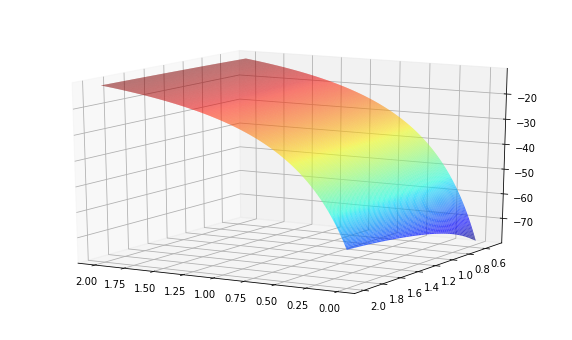

In [22]:

a, y = np.meshgrid(a_grid, y_grid)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(a,
                y,
                v.T,
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.7,
                linewidth=0.25)

ax.view_init(15, 120)
plt.show()